<a href="https://colab.research.google.com/github/baharababah/Detectionof-IoT-Botnet-Attacks/blob/main/IDS_IoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
# import required packages
from google.colab import drive 
drive.mount('/content/drive/')
import pandas as pd 
import numpy as np
import os, gc, time, warnings
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec 
import seaborn as sns
import glob
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, BatchNormalization

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [58]:
# Read the dataset 
#The dataset https://www.kaggle.com/mkashifn/nbaiot-dataset
''' This function read the files of the dataset,
       add new column called Label that shows if the data is benign or intrusion ,
       then, the files are saved in one dataframe
       '''
path = r'/content/drive/My Drive/dataset'  # use your path
all_files = glob.glob(path + "/*.csv")
li = []
keywords = 'benign', 'gafgyt.combo', 'gafgyt.junk', 'gafgyt.scan', 'gafgyt.tcp', 'gafgyt.udp', 'mirai.ack', 'mirai.scan', 'mirai.syn', 'mirai.udp', 'mirai.udpplain'
for filename in all_files:
  df = pd.read_csv(filename, index_col=None, header=0)
  for keyword in keywords:
    if keyword in filename:
      df['Label'] = keyword
      li.append(df)
data = pd.concat(li, ignore_index=True)

In [45]:
# show the data
data.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,MI_dir_L0.1_mean,MI_dir_L0.1_variance,MI_dir_L0.01_weight,MI_dir_L0.01_mean,MI_dir_L0.01_variance,H_L5_weight,H_L5_mean,H_L5_variance,H_L3_weight,H_L3_mean,H_L3_variance,H_L1_weight,H_L1_mean,H_L1_variance,H_L0.1_weight,H_L0.1_mean,H_L0.1_variance,H_L0.01_weight,H_L0.01_mean,H_L0.01_variance,HH_L5_weight,HH_L5_mean,HH_L5_std,HH_L5_magnitude,HH_L5_radius,HH_L5_covariance,HH_L5_pcc,HH_L3_weight,HH_L3_mean,HH_L3_std,...,HH_jit_L0.1_variance,HH_jit_L0.01_weight,HH_jit_L0.01_mean,HH_jit_L0.01_variance,HpHp_L5_weight,HpHp_L5_mean,HpHp_L5_std,HpHp_L5_magnitude,HpHp_L5_radius,HpHp_L5_covariance,HpHp_L5_pcc,HpHp_L3_weight,HpHp_L3_mean,HpHp_L3_std,HpHp_L3_magnitude,HpHp_L3_radius,HpHp_L3_covariance,HpHp_L3_pcc,HpHp_L1_weight,HpHp_L1_mean,HpHp_L1_std,HpHp_L1_magnitude,HpHp_L1_radius,HpHp_L1_covariance,HpHp_L1_pcc,HpHp_L0.1_weight,HpHp_L0.1_mean,HpHp_L0.1_std,HpHp_L0.1_magnitude,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Label
0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,1.000000,60.000000,0.000000,...,0.000000,1.000000,1.505662e+09,0.00000,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,1.000000,60.00000,0.000000,60.00000,0.000000,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,benign
1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000005,1.000032,353.999619,0.004575,1.031757,353.630645,4.295839,2.597515,346.619800,34.095047,5.319895,344.262695,22.188299,1.000000,354.000000,0.002143,354.000000,0.000005,0.0,0.0,1.000032,353.999619,0.067642,...,6976.104978,5.319895,5.801651e+01,12740.63613,1.000000,354.000000,0.002143,354.000000,0.000005,0.0,0.0,1.000032,353.999619,0.067642,353.999619,0.004575,0.0,0.0,1.031757,353.630645,2.072641,353.630645,4.295839,0.0,0.0,2.597515,346.61980,5.839096,346.61980,34.095047,0.0,0.0,5.319895,344.262695,4.710446,344.262695,22.188299,0.0,0.0,benign
2,1.857879,360.458980,35.789338,1.912127,360.275733,35.923972,1.969807,360.091968,35.991542,1.996939,360.009198,35.999915,1.999693,360.000920,35.999999,1.857879,360.458979,35.789342,1.912156,360.275456,35.928490,2.000605,359.813452,40.398803,3.589564,352.018840,100.081513,6.318264,347.703087,81.625077,1.857879,360.458979,5.982419,360.458979,35.789342,0.0,0.0,1.912156,360.275456,5.994038,...,5228.309522,6.318264,4.884116e+01,11171.88781,1.857879,360.458979,5.982419,360.458979,35.789342,0.0,0.0,1.912156,360.275456,5.994038,360.275456,35.928490,0.0,0.0,2.000605,359.813452,6.356005,359.813452,40.398803,0.0,0.0,3.589564,352.01884,10.004075,352.01884,100.081513,0.0,0.0,6.318264,347.703087,9.034660,347.703087,81.625077,0.0,0.0,benign
3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0,1.000000,337.000000,0.000000,...,0.000000,1.000000,1.505662e+09,0.00000,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0,1.000000,337.00000,0.0000

In [46]:
data.dtypes

MI_dir_L5_weight         float64
MI_dir_L5_mean           float64
MI_dir_L5_variance       float64
MI_dir_L3_weight         float64
MI_dir_L3_mean           float64
                          ...   
HpHp_L0.01_magnitude     float64
HpHp_L0.01_radius        float64
HpHp_L0.01_covariance    float64
HpHp_L0.01_pcc           float64
Label                     object
Length: 116, dtype: object

In [59]:
# Find out columns with missing values
datacopy = data.copy(deep=True)
data.isnull().sum(axis=0)

MI_dir_L5_weight         0
MI_dir_L5_mean           0
MI_dir_L5_variance       0
MI_dir_L3_weight         0
MI_dir_L3_mean           0
                        ..
HpHp_L0.01_magnitude     0
HpHp_L0.01_radius        0
HpHp_L0.01_covariance    0
HpHp_L0.01_pcc           0
Label                    0
Length: 116, dtype: int64

In [60]:
from sklearn.utils import shuffle
data = shuffle(data)

In [61]:
# take only 50000 rows for feature selection because of the RAM SIZE restriction i have. 
n = 50000
data = data.iloc[:n]

In [62]:
data['Label'].unique()

array(['gafgyt.combo', 'mirai.udp', 'mirai.ack', 'mirai.udpplain',
       'mirai.syn', 'gafgyt.udp', 'mirai.scan', 'benign', 'gafgyt.scan',
       'gafgyt.junk', 'gafgyt.tcp'], dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4428508490>]],
      dtype=object)

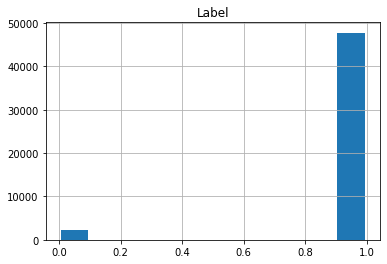

In [63]:
# Replace 'label' values to numbers as hist method requires numerical columns
data['Label'].replace({'benign': 0, 'gafgyt.combo': 1, 'gafgyt.junk': 1, 'gafgyt.scan': 1, 'gafgyt.tcp': 1, 'gafgyt.udp': 1, 'mirai.ack': 1, 'mirai.scan': 1, 'mirai.syn': 1, 'mirai.udp': 1, 'mirai.udpplain': 1},inplace=True)
# Create pandas histogram to check if the data is unbalanced
data.hist(column= 'Label', rwidth = 0.9)

In [64]:
x = data.drop('Label', axis=1)
y = data['Label']

In [65]:
# bakance the data using SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f44172661d0>]],
      dtype=object)

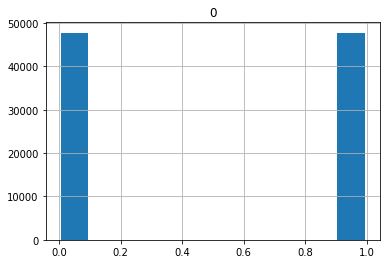

In [66]:
yshow = pd.DataFrame(y)
yshow.hist(rwidth = 0.9)

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils

In [67]:
# information gain
x = pd.DataFrame(x)
y = pd.DataFrame(y)
fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(x, y)
fs_support = fs.get_support()
fs_feature = x.loc[:, fs_support].columns.tolist()
fs_feature = list(fs_feature)
# information gain for each column
for i in range(len(fs.scores_)):
  print(fs_feature[i], ':', fs.scores_[i])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0 : 0.5696680653598862
1 : 0.5947780540775232
2 : 0.30563493727542057
3 : 0.5856284160910399
4 : 0.6117956334189458
5 : 0.2982896018741781
6 : 0.6468896206097783
7 : 0.6457066169388658
8 : 0.3680153104028754
9 : 0.6924364067071714
10 : 0.6721740598251965
11 : 0.5800652158093538
12 : 0.6925166539989497
13 : 0.6915788001132752
14 : 0.6173488594572131
15 : 0.5686383089278935
16 : 0.5945564679103397
17 : 0.30587546728188575
18 : 0.5852516749211916
19 : 0.611743541632348
20 : 0.2986618498213198
21 : 0.6470605644098786
22 : 0.6456577472255215
23 : 0.36674889186040005
24 : 0.692429425319551
25 : 0.6720840749964243
26 : 0.5800411151541525
27 : 0.6925190611362547
28 : 0.6912871790142411
29 : 0.6176015048804095
30 : 0.24266406495216297
31 : 0.5863191335500124
32 : 0.16162824058452085
33 : 0.6849497284557333
34 : 0.07724014559789083
35 : 0.0022157725005005346
36 : 0.028940090224341075
37 : 0.25489942709891333
38 : 0.5937098531875358
39 : 0.1448280527925272
40 : 0.6847398456399725
41 : 0.078882973

In [68]:
# get the first highest 30 features resulted from info gain
fs = SelectKBest(score_func=mutual_info_classif, k=30)
fs.fit(x, y)
fs_support = fs.get_support()
fs_feature = x.loc[:, fs_support].columns.tolist()
fs_feature = list(fs_feature)
print(fs_feature)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[9, 10, 12, 13, 24, 25, 27, 28, 33, 40, 45, 47, 51, 52, 54, 58, 59, 61, 66, 69, 72, 74, 77, 83, 90, 97, 101, 104, 108, 111]


In [69]:
x = x.iloc[:, [9, 10, 12, 13, 24, 25, 27, 28, 33, 40, 45, 47, 51, 52, 54, 58, 59, 61, 66, 69, 72, 74, 77, 83, 90, 97, 101, 104, 108, 111]]

In [70]:
# normalize the data
from sklearn import preprocessing
x = preprocessing.normalize(x)

In [71]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1234, stratify=y)

In [74]:
# Deep Neural Network classifier
def getdnnclf():
    clf = Sequential()
    clf.add(Dense(32, input_dim =30 , activation = 'relu'))
    clf.add(BatchNormalization())
    clf.add(Dense(16, activation = 'relu'))
    clf.add(Dense(8, activation = 'relu'))
    clf.add(Dense(1, activation = 'sigmoid'))
    clf.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return clf

In [75]:
# training on DNN classifier
clf = getdnnclf()
clf.fit(x_train, y_train, epochs = 10 , verbose = 0)
y_pred = (clf.predict(x_test) >= 0.5).astype(int)
dnn_accuracy = accuracy_score(y_test, y_pred)
print('DNN accuracy:', dnn_accuracy) 

DNN accuracy: 0.9990575422797006


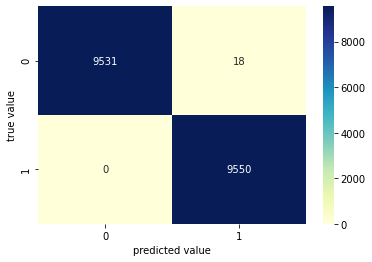

In [76]:
#Prediction of test set
import seaborn as sns
#print confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

In [77]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.999058
Precision: 0.998119
Recall: 1.000000
F1 score: 0.999058


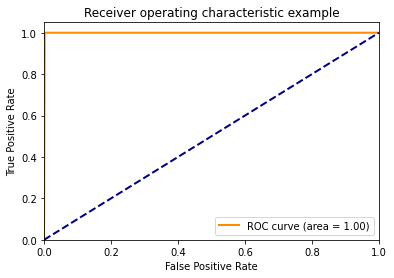

In [79]:
#  build roc curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()